# Using a Deep Learning Framework: Autoencoders
## Advanced Concepts in Machine Learning (2122-KEN4154) - Assignment 2
### authors: Tom Šabanov (i6299190) and Wiebke Hennig (i6298916)

<img src="Logo_UniMaastricht.svg.png" width=60/>

### Maastricht University

***

### Abstract

This document contains several implementations as well as discussions concerning convolutional autoencoders.


### Contents
- [Preparations](#prep)
- [Exercise 1.1](#ex11)
- [Exercise 1.2](#ex12)
- [Exercise 2.1](#ex21)
- [Exercise 2.2](#ex22)
- [Exercise 3.1](#ex31)
- [Exercise 3.2](#ex32)

### Resources
- CIFAR-10 dataset (https://www.cs.toronto.edu/ ̃kriz/cifar.html)

***

<a id="prep"></a>
### Preparations

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

***

<a id="ex11"></a>
### Exercise 1.1
First, the dataset needs to be loaded:

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

The used function of keras automatically returns the dataset split into training and testing data (50.000 train, 10.000 test samples).
<br>x_train: uint8 NumPy array of grayscale image data with shapes (50000, 32, 32, 3), containing the training data. Pixel values range from 0 to 255.
<br>y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (50000, 1) for the training data.
<br>x_test: uint8 NumPy array of grayscale image data with shapes (10000, 32, 32, 3), containing the test data. Pixel values range from 0 to 255.
<br>y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000, 1) for the test data.
<br>(source: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)

Afterwards, we combine training and test data together and normalize them:

In [5]:
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
X = np.concatenate((x_train, x_test), axis=0).astype('float32')/255.0

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
Y = np.concatenate((y_train, y_test), axis=0).astype('float32')/255.0

This was a necessary step in order to further use the data, as it needs to be split into ...
- train (80 %)
- validation (10 %)
- test (10 %)

... datasets. 

This will be performed by the train_test_split method from sklearn.model_selection:

In [6]:
X_train, X_rem, Y_train, y_rem = train_test_split(X,Y, train_size=0.8)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,y_rem, test_size=0.5)

Finally, there are three datasets of the following sizes:
- X_train, y_train : 48000

In [8]:
print(X_train.shape)
# X_train shape (48000, 32, 32, 3)

(48000, 32, 32, 3)


- X_valid, y_valid : 6000

In [9]:
print(X_valid.shape)
# X_valid shape (6000, 32, 32, 3)

(6000, 32, 32, 3)


- X_test, y_test : 6000

In [10]:
print(X_test.shape)
# X_test shape (6000, 32, 32, 3)

(6000, 32, 32, 3)


***

<a id="ex12"></a>
### Exercise 1.2

Now, the Convolutional Auto-Encoder (CAE) will be constructed using keras.
<br>After this setup, the model is fitted to the data using the corresponding keras method.
<br>These two steps are included in the following method:

In [11]:
def trainNetwork(loss_fnc, epochs, saveTo):
    #  Construct the CAE
    img = keras.Input(shape=(32,32, 3))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',strides=1)(img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',strides=1)(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',strides=1)(x)

    autoencoder = keras.Model(img, decoded)
    autoencoder.compile(optimizer='adam', loss=loss_fnc)
    
    # Fit the model and save it
    hist = autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(X_valid, X_valid),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
    
    autoencoder.save(saveTo)
    
    return (autoencoder, hist)

The CAE's structure can be plotted within a selectable file:

In [12]:
def printModelStructure(autoencoder, filename):
    plot_model(autoencoder, to_file = filename)

Finally, the result of the training is inspected by plotting the test error:

In [13]:
def plotLoss(hist,saveTo, loss, label, x, y):
    # Plot the training loss
    loss_values = hist.history[loss]
    epochs = range(1, len(loss_values)+1)

    plt.plot(epochs, loss_values, label=label)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

    plt.show()
    plt.savefig(saveTo)

To visualize this result more clearly, the following method prints the original and predicted pictures next to each other:

In [14]:
def drawOriginalAndPredicted(original, predicted, num=10):
    plt.figure(figsize=(20, 4))
    for i in range(num):
        # display original
        ax = plt.subplot(2, num, i + 1)
        plt.imshow(original[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, num, i + 1 + num)
        plt.imshow(predicted[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Using the methods above, two different approaches for CAE's are tested.
<br> For both experiments, the number of iterations is set to 10. The difference lies in the loss function:
1. MSE (mean squared error)

Epoch 1/10
375/375 [==============================] - 24s 63ms/step - loss: 0.0174 - val_loss: 0.0100
Epoch 2/10
375/375 [==============================] - 24s 63ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 3/10
375/375 [==============================] - 24s 63ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 4/10
375/375 [==============================] - 23s 63ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 5/10
375/375 [==============================] - 24s 64ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 6/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 7/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 8/10
375/375 [==============================] - 23s 62ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 9/10
375/375 [==============================] - 24s 63ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 10/10
375/375 [==============================] - 24s 63ms/step - loss: 0.005

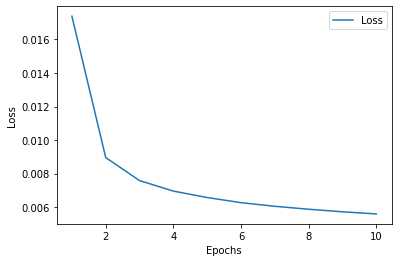

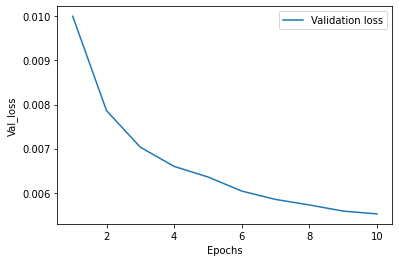

<Figure size 432x288 with 0 Axes>

In [15]:
(model, hist) = trainNetwork('mean_squared_error', 10, './ex_1_2_mse')
plotLoss(hist,'1_2_mse_loss.png', 'loss', 'Loss','Epochs','Loss')
plotLoss(hist,'1_2_mse_val_loss.png', 'val_loss', 'Validation loss','Epochs','Val_loss')
# Loss = 0.0053, validation loss = 0.0053

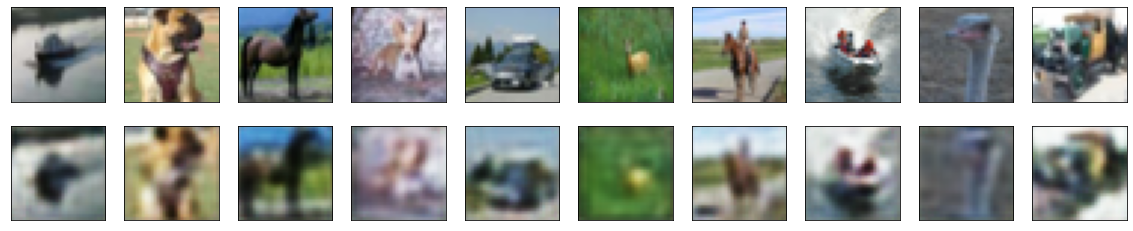

In [16]:
drawOriginalAndPredicted(X_test,model.predict(X_test))

As the plots show, the loss and validation loss decrease approximately logarithmic, both ending up to be 0.0053.
<br>The graphs also indicate that the number of epochs do not need to be increased drastically, because the pitch has already reached such a low value that most likely, it is going to take many additional iterations to see a distinct impact on the model's quality.

2. binary cross entropy

Epoch 1/10
375/375 [==============================] - 23s 61ms/step - loss: 0.5902 - val_loss: 0.5720
Epoch 2/10
375/375 [==============================] - 23s 62ms/step - loss: 0.5691 - val_loss: 0.5676
Epoch 3/10
375/375 [==============================] - 24s 63ms/step - loss: 0.5664 - val_loss: 0.5658
Epoch 4/10
375/375 [==============================] - 22s 58ms/step - loss: 0.5649 - val_loss: 0.5646
Epoch 5/10
375/375 [==============================] - 22s 58ms/step - loss: 0.5639 - val_loss: 0.5639
Epoch 6/10
375/375 [==============================] - 22s 60ms/step - loss: 0.5632 - val_loss: 0.5633
Epoch 7/10
375/375 [==============================] - 24s 63ms/step - loss: 0.5627 - val_loss: 0.5628
Epoch 8/10
375/375 [==============================] - 24s 63ms/step - loss: 0.5622 - val_loss: 0.5624
Epoch 9/10
375/375 [==============================] - 24s 63ms/step - loss: 0.5618 - val_loss: 0.5621
Epoch 10/10
375/375 [==============================] - 25s 66ms/step - loss: 0.561

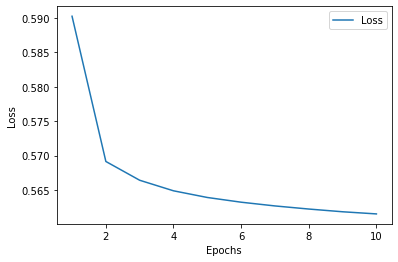

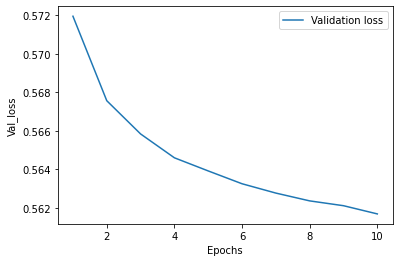

<Figure size 432x288 with 0 Axes>

In [17]:
(model2, hist2) = trainNetwork('binary_crossentropy', 10, './ex_1_2_bce')
plotLoss(hist2,'1_2_bce_loss.png', 'loss', 'Loss','Epochs','Loss')
plotLoss(hist2,'1_2_bce_val_loss.png', 'val_loss', 'Validation loss','Epochs','Val_loss')
# Loss = 0.5609 | validation loss = 0.5606    -> bigger loss than with MSE

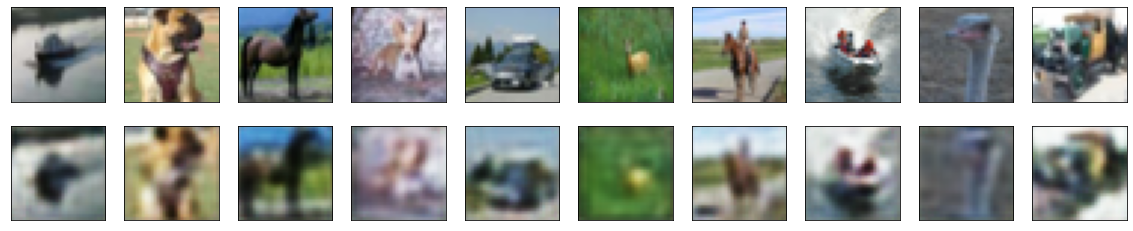

In [18]:
drawOriginalAndPredicted(X_test,model.predict(X_test))

Using binary cross entropy as a loss function seems to (in this case, according to the plots and results) cause higher errors than using MSE.

***

<a id="ex21"></a>
### Exercise 2.1

Q: What is the size of the latent space representation of the above network?

A: There are 2 max_pooling layers of (2x2), which means the input volume (W) to our latent space representation is going to be 8x8x12

W = 8, K = 3, P=S=1, C = 16

Size of latent space representation = (8)^2 * 16 = 64 * 16 = 1024

***

<a id="ex22"></a>
### Exercise 2.2

***

<a id="ex31"></a>
### Exercise 3.1

In this step, we aim to train the model to predict rgb images using grayscale images as an input.

To do this, we first created a function which reduces a fully colored image to a black-and-white version.
<br>To compute a single pixel's value, we apply the average method.

source of the formula: https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/

In [7]:
def translateToGray(image):
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    gray_values = (r + g + b)/3
    return np.expand_dims(gray_values, axis = -1)

Using this method, the datasets for training, validating and testing are transformed to grayscale:

In [8]:
X_train_gray = []
for image in X_train:
    X_train_gray.append(translateToGray(image))
X_train_g = np.asarray(X_train_gray)

X_valid_gray = []
for image in X_valid:
    X_valid_gray.append(translateToGray(image))
X_valid_g = np.asarray(X_valid_gray)

X_test_gray = []
for image in X_test:
    X_test_gray.append(translateToGray(image))
X_test_g = np.asarray(X_test_gray)

To show this translation, some of the original images will be printed with their grayscaled versions below them:

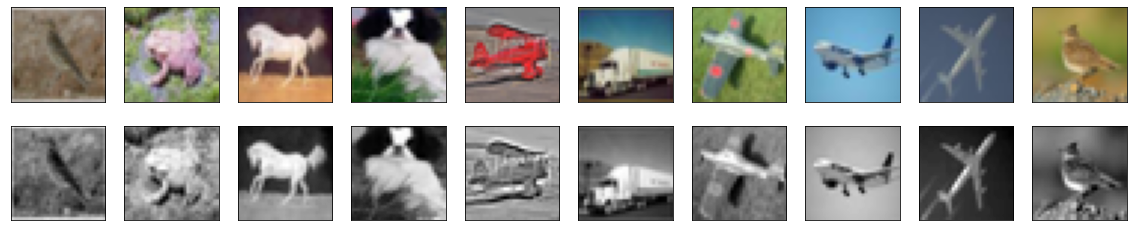

In [9]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(X_train_g[i].reshape(32, 32, 1),cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As indicated in the assignment, it might be a good idea to only predict the color distributions (chrominance values) of the final image, as the grayscale already contains all the necessary shape information. Regarding this to be a promising approach, we tried to do this first.

Accordingly, we introduced a function which creates the chrominance version of an image:

In [14]:
def translateToChrominance(image):
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]

    image_c = np.copy(image)
    
    image_c[:,:,0] = r/(r + g + b)
    image_c[:,:,1] = g/(r + g + b)
    image_c[:,:,2] = b/(r + g + b)

    return image_c

Using this method, the datasets for training, validating and testing are transformed to chrominance:

In [15]:
X_train_chrom = []
for image in X_train:
    X_train_chrom.append(translateToChrominance(image))
X_train_c = np.asarray(X_train_chrom)

X_valid_chrom = []
for image in X_valid:
    X_valid_chrom.append(translateToChrominance(image))
X_valid_c = np.asarray(X_valid_chrom)

X_test_chrom = []
for image in X_test:
    X_test_chrom.append(translateToChrominance(image))
X_test_c = np.asarray(X_test_chrom)

/tmp/ipykernel_8699/2790105666.py:8: RuntimeWarning: invalid value encountered in true_divide
  image_c[:,:,0] = r/(r + g + b)
/tmp/ipykernel_8699/2790105666.py:9: RuntimeWarning: invalid value encountered in true_divide
  image_c[:,:,1] = g/(r + g + b)
/tmp/ipykernel_8699/2790105666.py:10: RuntimeWarning: invalid value encountered in true_divide
  image_c[:,:,2] = b/(r + g + b)


As the warnings indicate, some values are now nan and need to be replaced by 0.

In [16]:
X_train_c = np.nan_to_num(X_train_c,0)
X_valid_c = np.nan_to_num(X_valid_c,0)
X_test_c = np.nan_to_num(X_test_c,0)

To show this translation, some of the original images will be printed with their chrominized versions below them:

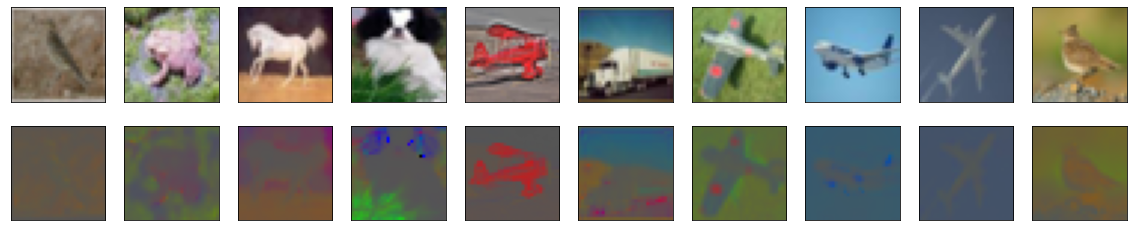

In [17]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(X_train_c[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

To test the theory that the chrominance and grayscale values can be combined to create the original picture, we tried to achieve that goal for the ideal example (using X_train_g and X_train_c):

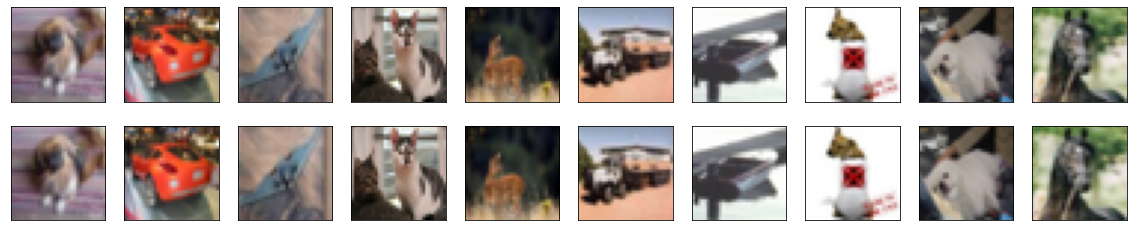

In [58]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow((X_train_c[i]*X_train_g[i]*3).reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As was to be proven, the grayscale and chrominance values can be combined to the original image if both reflect the original image.

Based on this knowledge, the new autoencoder is created:

In [18]:
# create the CAE
img = keras.Input(shape=(32,32,1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',strides=1)(img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',strides=1)(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',strides=1)(x)

autoencoder = keras.Model(img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model and save it
hist = autoencoder.fit(X_train_g, X_train_c,
            epochs=10,
            batch_size=128,
            shuffle=True,
            validation_data=(X_valid_g, X_valid_c),
            callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

2021-11-09 18:40:42.176360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 18:40:42.205178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-09 18:40:42.205203: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-09 18:40:42.207668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Epoch 1/10
375/375 [==============================] - ETA: 0s - loss: 0.0064

2021-11-09 18:41:02.743971: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73728000 exceeds 10% of free system memory.


375/375 [==============================] - 21s 54ms/step - loss: 0.0064 - val_loss: 0.0050
Epoch 2/10
200/375 [===============>..............] - ETA: 8s - loss: 0.0051

KeyboardInterrupt: 

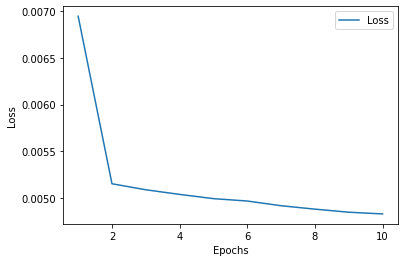

In [79]:
# Plot the training loss
loss_values = hist.history['loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


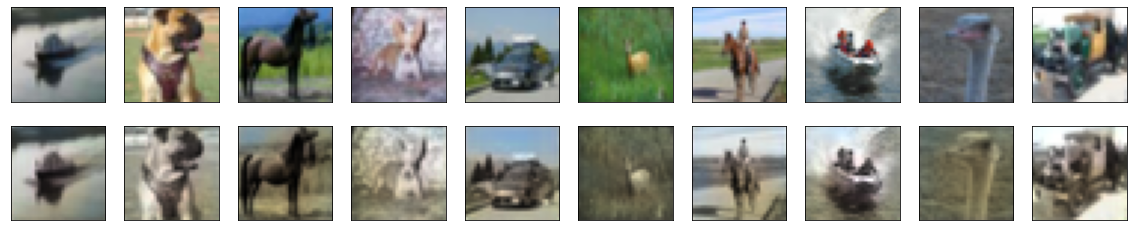

In [82]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    #print((autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3)[(autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3)>1])
    plt.imshow((autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As we can see here, the created model predicting chrominance pictures, despite having a low loss value (0.0047), produces (judged by human eyes) quite inaccurate results: the colors are mostly lost, leaving the pictures to appear 'old' (in other words brown-grayish).
<br>Note: the 'Clipping' warnings indicate that some results are no longer in range 0..1. This can unfortunately happen in the calculation of the rgb values, because the predicted chrominance values (which always lie between 0 and 1) are multiplied with the grayscale and 3. The closer the result gets to the true value however, the less this will occur (because in the true values' recalculation this does not happen as seen above).

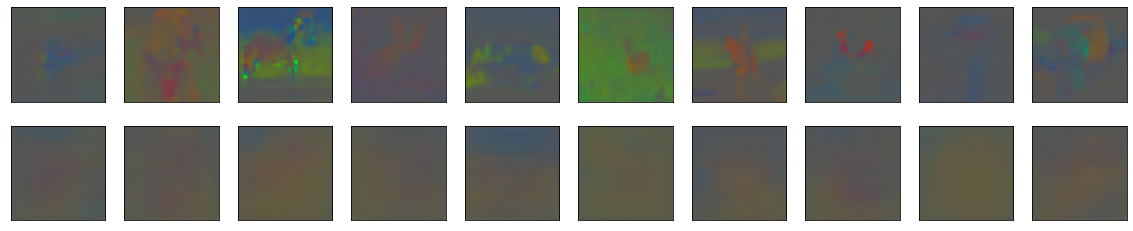

In [84]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test_c[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    #print((autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3)[(autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3)>1])
    plt.imshow((autoencoder.predict(X_test_g)[i]).reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As we can see above, the true chrominance values (upper row) include much more intense and distinct color sectionings then the predicted ones (lower row). Supposedly, this indistinctiveness in the predictions (overlapping between the color regions) cause the final recomposed pictures to appear mainly brown.

Seeing this, we wondered if (against our expectations) it might be more accurate to try to predict the full rgb values (disregarding the hint we used above), so we realized the model originally described in the exercise:

In [ ]:
# create the CAE
img = keras.Input(shape=(32,32,1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',strides=1)(img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',strides=1)(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',strides=1)(x)

autoencoder = keras.Model(img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model and save it
hist = autoencoder.fit(X_train_g, X_train,
            epochs=10,
            batch_size=128,
            shuffle=True,
            validation_data=(X_valid_g, X_valid),
            callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0190 - val_loss: 0.0121
Epoch 2/10
375/375 [==============================] - 21s 57ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 3/10
375/375 [==============================] - 20s 54ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 4/10
375/375 [==============================] - 20s 52ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 5/10
375/375 [==============================] - 20s 53ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 6/10
375/375 [==============================] - 21s 56ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 7/10
375/375 [==============================] - 21s 56ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 8/10
375/375 [==============================] - 22s 58ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 9/10
375/375 [==============================] - 21s 56ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 10/10
375/375 [==============================] - 23s 61ms/step - loss: 0.009

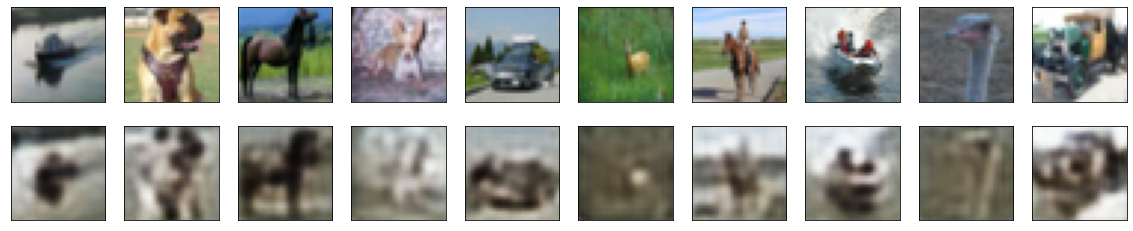

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow((autoencoder.predict(X_test_g)[i]).reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As we can see here, the prediction error increases (value 0.0093) compared to the chrominance-predicting network we implemented beforehand.
<br>Looking at the pictures to describe this more verbally, we can see that the colors did not improve in a distinguishable way and the motives appear very blurred.

***

<a id="ex32"></a>
### Exercise 3.2

Q: What are the results of Exercise 3.1? (Why) are there shortcomings in the network?

A:      Detailed analysis, discussions and interpretations of the steps are already included in [Exercise 3.1](#ex31).
<br>    To summarize, we can confirm that trying to predict the full rgb values from grayscale produces worse results than attempting to only predict the chrominance.
<br>This also makes sense regarding the fact that in case of a full prediction, the result includes errors in the already given part of the pictures (conturing, given by the grayscale which is the input). If we only try to predict the missing information (the chrominance values) and combine the in- and output afterwards, the grayscale information can never be lost, so it makes sense for this approach to produce better results.

Q: What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this application?

A: In [Exercise 3.1](#ex31), we already implemented the suggested improvement to the originally described network (directly predicting the complete rgb values) by simply predicting the chrominance values. <br>Other possible enhancements to produce better solutions will be tested in the following:

1. Increase number of iterations

In [85]:
# create the CAE
img = keras.Input(shape=(32,32,1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',strides=1)(img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',strides=1)(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(12, (3, 3), activation='relu', padding='same',strides=1)(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same',strides=1)(x)

autoencoder = keras.Model(img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model and save it
hist = autoencoder.fit(X_train_g, X_train_c,
            epochs=100,
            batch_size=128,
            shuffle=True,
            validation_data=(X_valid_g, X_valid_c),
            callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
375/375 [==============================] - 25s 64ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 2/100
375/375 [==============================] - 24s 64ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 3/100
375/375 [==============================] - 26s 68ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 4/100
375/375 [==============================] - 27s 72ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 5/100
375/375 [==============================] - 25s 68ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 6/100
375/375 [==============================] - 25s 66ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 7/100
375/375 [==============================] - 25s 67ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/100
375/375 [==============================] - 24s 64ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/100
375/375 [==============================] - 24s 65ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/100
375/375 [==============================] - 24s 63ms/step - l

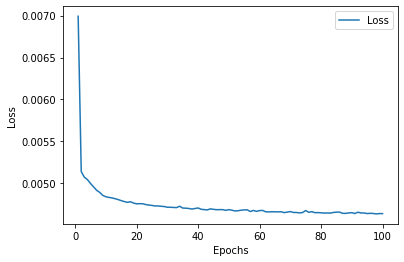

In [86]:
# Plot the training loss
loss_values = hist.history['loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


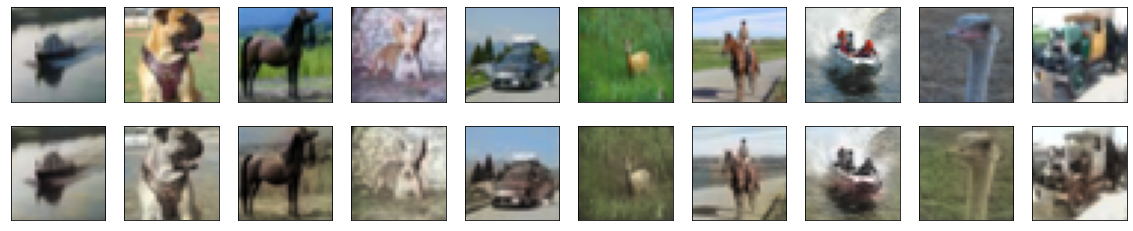

In [87]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    #print((autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3)[(autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3)>1])
    plt.imshow((autoencoder.predict(X_test_g)[i]*X_test_g[i]*3).reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [88]:
test_loss = autoencoder.evaluate(X_test_g, X_test_c, batch_size=128)

47/47 [==============================] - 0s 10ms/step - loss: 0.0046
